# Lab 3
### Rohan Nagar

*Note: This assignment is done in Python 3.*

In [2]:
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [3]:
# This function takes in a pandas dataframe and returns a preprocessed form of the data.
# Deals with missing values and converts categorical data to a numerical representation.
def preprocess_data(data):
    data = data.replace('?', np.nan)
    
    # Replace missing categorical data with most-frequent and missing numerical data with mean
    data = data.fillna(pd.Series(
            [data[c].value_counts().index[0] if data[c].dtype == np.dtype('O') else data[c].mean() for c in data],
            index=data.columns))

    # Convert categorical data into numerical labels
    for c in data:
        if data[c].dtype == np.dtype('O'):
            encoder = preprocessing.LabelEncoder()
            data[c] = encoder.fit_transform(data[c])
            
    return data

### Report Question (Missing Data)

1. I dealt with missing data in two different ways. If the data was categorical, then I filled in that missing categorical data with the most frequently occuring type. For example, if a row is missing the `workclass` information, and `Private` is the most common `workclass`, then that row will be filled in with the value `Private`.

  The second way I dealt with missing data was if it was numerical. In this case, if a row was missing data, it was filled in with the average of all available data in that column. For example, if a row is missing the `capital-gain` feature, then the average of `capital-gain` from all the data will be used to fill in the row.

## Part 1 - SVMs

First, let's read in the training data and deal with missing values by calling our `preprocess_data` function.

In [4]:
# Read data and preprocess
data = pd.read_csv("../dataset/train.data", sep=', ', header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary'], engine='python')
data = preprocess_data(data)

print(data.shape)
data.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


Now we'll split the data into train and validation. We are going to use a standard percentage split. We are also going to try different test sizes to see which gives us the best accuracy. These sizes are 30%, 40%, 50%, 60%, and 70%; where those percentages represent the test size. We'll run a standard SVM RBF model to determine the best accuracy on the validation set.

In [5]:
# Slice columns into independent and dependent data
indep_data, dep_data = data.iloc[:, :14], data.iloc[:, 14]

sizes = [0.30, 0.40, 0.50, 0.60, 0.70]
for s in sizes:
    # Split into train and validation
    X_train, X_valid, y_train, y_valid = train_test_split(indep_data, dep_data, test_size=s, random_state=42)
    
    # Scale the data
    temp_scale = preprocessing.StandardScaler()
    X_train, X_validation = temp_scale.fit_transform(X_train), temp_scale.transform(X_valid)
    
    # Run a test SVM so that we can see the accuracy on the validation set
    temp_svm = SVC()
    temp_svm.fit(X_train, y_train)
    temp_score = accuracy_score(temp_svm.predict(X_valid), y_valid)
    print("SVM Accuracy with a split test size of {}: {}".format(s, temp_score))

SVM Accuracy with a split test size of 0.3: 0.7631282628723514
SVM Accuracy with a split test size of 0.4: 0.7596928982725528
SVM Accuracy with a split test size of 0.5: 0.7589214421718568
SVM Accuracy with a split test size of 0.6: 0.7595331934278549
SVM Accuracy with a split test size of 0.7: 0.760277278111701


As we can see, a split test size of 0.30 gave us the best accuracy on the validation set. So, let's use that size to do our actual split.

In [6]:
# Split into train and validation
indep_train, indep_validation, dep_train, dep_validation = train_test_split(indep_data, dep_data, test_size=0.30, random_state=42)

# Scale the data
scale = preprocessing.StandardScaler()
indep_train, indep_validation = scale.fit_transform(indep_train), scale.transform(indep_validation)

<a id='svm_kernel'></a>
Now to train SVMs! One each of RBF, Linear, and Polynomial. After that, we'll play with 3 other parameters to the SVM and then use the best model we can by playing with the parameters.

In [7]:
svm_rbf = SVC(kernel='rbf')
svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')

svm_rbf.fit(indep_train, dep_train)
svm_linear.fit(indep_train, dep_train)
svm_poly.fit(indep_train, dep_train)

rbf_score = accuracy_score(svm_rbf.predict(indep_validation), dep_validation)
linear_score = accuracy_score(svm_linear.predict(indep_validation), dep_validation)
poly_score = accuracy_score(svm_poly.predict(indep_validation), dep_validation)

print("RBF Accuracy: {}".format(rbf_score))
print("Linear Accuracy: {}".format(linear_score))
print("Polynomial Accuracy MSE: {}".format(poly_score))

RBF Accuracy: 0.8505476507319071
Linear Accuracy: 0.8216808271061521
Polynomial Accuracy MSE: 0.8458388780837343


<a id='svm_param_tweaks'></a>
It looks like the RBF kernel gave us the best accuracy on the validation set, with the polynomial kernel close behind. The linear kernel is the worst of the three.

SVM Accuracy for C=0.1: 0.8430750332685024
SVM Accuracy for C=0.25: 0.8472719828027434
SVM Accuracy for C=0.5: 0.8510594738458389
SVM Accuracy for C=1.0: 0.8505476507319071
SVM Accuracy for C=1.5: 0.8507523799774798
SVM Accuracy for C=2.0: 0.8513665677141979
SVM Accuracy for C=4.0: 0.8515712969597707


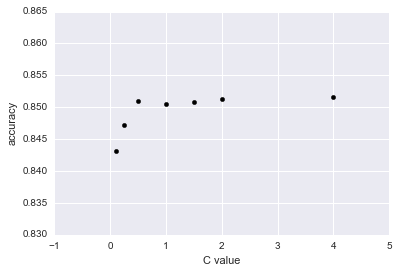

In [8]:
# Train some more SVMs, changing different parameters
# Change C parameter
params = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 4.0]
accuracy = []

for p in params:
    svm = SVC(C=p)
    svm.fit(indep_train, dep_train)
    score = accuracy_score(svm.predict(indep_validation), dep_validation)
    accuracy.append(score)
    print("SVM Accuracy for C={}: {}".format(p, score))
    
plt.scatter(params, accuracy, color='black')
plt.xlabel('C value')
plt.ylabel('accuracy')
plt.show()
sns.despine()

The `C` parameter in the SVC model reflects a tradeoff between reducing misclassification and model simplicity. With a lower `C` value, the decision surface is smooth, but there are potentiall more misclassifications. With a high `C` value, the model will try to classify all training data correctly by giving the model more freedom to select more support vectors.

As we can see from the plot, accuracy improves dramatically up to `C=0.5`, which is expected. However, after that the accuracy levels off. From this, we can assume that selecting more support vectors does not help improve accuracy on this set of data. Since there isn't much of a difference from 2.0 to 4.0, we will use a value of 2.0 in our final model to reduce complexity.

SVM Accuracy for gamma=0.1: 0.8517760262053434
SVM Accuracy for gamma=0.25: 0.8464530658204524
SVM Accuracy for gamma=0.5: 0.8358071450506704
SVM Accuracy for gamma=1.0: 0.8193264407820657
SVM Accuracy for gamma=1.5: 0.8092947077490019
SVM Accuracy for gamma=2.0: 0.8005937148121609
SVM Accuracy for gamma=4.0: 0.7841130105435562


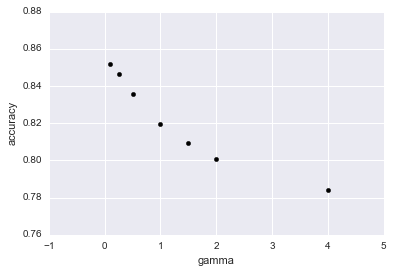

In [9]:
# Change gamma parameter
params = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 4.0]
accuracy = []

for p in params:
    svm = SVC(gamma=p)
    svm.fit(indep_train, dep_train)
    score = accuracy_score(svm.predict(indep_validation), dep_validation)
    accuracy.append(score)
    print("SVM Accuracy for gamma={}: {}".format(p, score))
    
plt.scatter(params, accuracy, color='black')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.show()
sns.despine()

The `gamma` parameter in the SVC model defines how "far" a single data point influences the model. Low values of `gamma` means that a single data example will reach "far", while a high value means "close". Intuitively, this means that low `gamma` values will produce a higher accuracy.

This can be seen in the plot above. As `gamma` increases, the accuracy decreases. Thus, we want a small value of `gamma` for our model.

In [10]:
# Change probability parameter 
svm = SVC() # default is False
svm.fit(indep_train, dep_train)
true_shrinking_score = accuracy_score(svm.predict(indep_validation), dep_validation)
print("SVM Accuracy without probability: {}".format(true_shrinking_score))

svm = SVC(probability=True)
svm.fit(indep_train, dep_train)
false_shrinking_score = accuracy_score(svm.predict(indep_validation), dep_validation)
print("SVM Accuracy with probability: {}".format(false_shrinking_score))

SVM Accuracy without probability: 0.8505476507319071
SVM Accuracy with probability: 0.8505476507319071


<a id='svm_validation_result'></a>
The `probability` parameter decides whether to use probability estimates when fitting the model or not. Turning on probability estimates slows down the fitting of the model since it has to calcuate the probability estimates.

However, as we can see from the results above, this had no effect on the accuracy of our model in this case. It seems that the data is well represented without using probability estimates.

Let's now combine our knowledge of how these parameters affect the accuracy to produce a final model that we will run the test data on.

In [11]:
# This is the final model
svm = SVC(kernel='rbf', C=2.0, gamma=0.1, probability=False)
svm.fit(indep_train, dep_train)
score = accuracy_score(svm.predict(indep_validation), dep_validation)
print("SVM Accuracy on validation: {}".format(score))

SVM Accuracy on validation: 0.8507523799774798


<a id='svm_test_result'></a>
Finally, let's run our final model on the test data.

In [12]:
# Bring in test data and process it
test_data = pd.read_csv("../dataset/test.data", sep=', ', header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary'], engine='python')
test_data = preprocess_data(test_data)

print(test_data.shape)
test_data.head()

(16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,37,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,37,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,37,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,37,1
4,18,3,103497,15,10,4,9,3,4,0,0,0,30,37,0


In [13]:
# Split and transform the independent data to run on the model
indep_test_data, dep_test_data = test_data.iloc[:, :14], test_data.iloc[:, 14]
indep_test_data = scale.transform(indep_test_data)

score = accuracy_score(svm.predict(indep_test_data), dep_test_data)
print("SVM Accuracy on test data: {}".format(score))

SVM Accuracy on test data: 0.8505620047908605


### Report Questions

1. The data was split using a standard percentage. The percentages that were tried were 30%, 40%, 50%, 60%, and 70%; where those percentages represent the test size. The 30% split gave the best accuracy on the validation set.
2. The accuracy for each kernel is displayed in the relevant code above. [[Here]](#svm_kernel)
3. Three other parameters were tweaked and the plots or results are displayed in the relevant code above. [[Here]](#svm_param_tweaks)

##### Final SVM Questions
1. The final parameters used in my model were:
    - kernel: RBF
    - C: 2.0
    - gamma: 0.1
    - probability: False
2. I did not remove any features. I felt that all of the features in the data were meaningful features that could provide some insight to the salary of the person. Therefore, I wanted to use all of the features so as to not miss something that the data could tell me.
3. The accuracy for the final model on the validation set is displayed in the relevant code above. [[Here]](#svm_validation_result)
4. The accuracy for the final model on the test data is displayed in the relevant code above. [[Here]](#svm_test_result)

## Part 2 - AdaBoostClassifier

<a id='boost_estimators'></a>
Next we're going to use the AdaBoostClassifier to fit our model. We'll try 8 different numbers of estimators and 10 different learning rates to try and get the best possible model.

Boost Accuracy for 10 estimators: 0.8513665677141979
Boost Accuracy for 20 estimators: 0.8575084450813799
Boost Accuracy for 30 estimators: 0.8596581021598936
Boost Accuracy for 40 estimators: 0.860067560651039
Boost Accuracy for 50 estimators: 0.8616030299928344
Boost Accuracy for 100 estimators: 0.8660047087726481
Boost Accuracy for 200 estimators: 0.8678472719828028
Boost Accuracy for 400 estimators: 0.8724536800081891


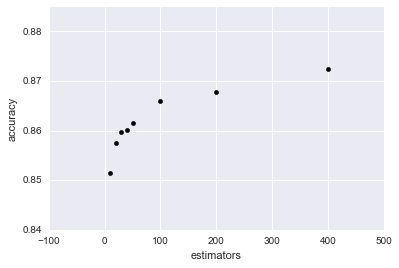

In [14]:
estimators = [10, 20, 30, 40, 50, 100, 200, 400]
accuracy = []

for n in estimators:
    boost = AdaBoostClassifier(n_estimators=n)
    boost.fit(indep_train, dep_train)
    score = accuracy_score(boost.predict(indep_validation), dep_validation)
    accuracy.append(score)
    print("Boost Accuracy for {} estimators: {}".format(n, score))
    
plt.scatter(estimators, accuracy, color='black')
plt.xlabel('estimators')
plt.ylabel('accuracy')
plt.show()
sns.despine()

<a id='boost_learning_rate'></a>
We can see from the plot that as we increase the estimators, the accuracy increases as well. However, it starts to taper off as we get to a large number of estimators. This intuitively makes sense, because more estimators helps more with larger dataset sizes.

Boost Accuracy for learning rate of 0.1: 0.8446105026102979
Boost Accuracy for learning rate of 0.25: 0.8542327771522162
Boost Accuracy for learning rate of 0.4: 0.8558706111167981
Boost Accuracy for learning rate of 0.5: 0.8595557375371071
Boost Accuracy for learning rate of 0.6: 0.8609888422561163
Boost Accuracy for learning rate of 0.75: 0.8588391851776026
Boost Accuracy for learning rate of 1.0: 0.8616030299928344
Boost Accuracy for learning rate of 1.5: 0.8591462790459617
Boost Accuracy for learning rate of 2.0: 0.7631282628723514
Boost Accuracy for learning rate of 5.0: 0.2368717371276487


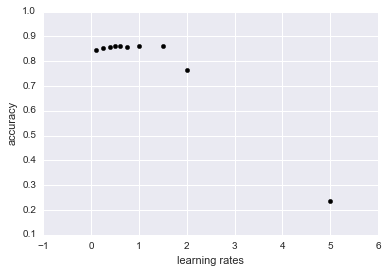

In [15]:
learning_rates = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0, 1.5, 2.0, 5.0]
accuracy = []

for rate in learning_rates:
    boost = AdaBoostClassifier(learning_rate=rate)
    boost.fit(indep_train, dep_train)
    score = accuracy_score(boost.predict(indep_validation), dep_validation)
    accuracy.append(score)
    print("Boost Accuracy for learning rate of {}: {}".format(rate, score))
    
plt.scatter(learning_rates, accuracy, color='black')
plt.xlabel('learning rates')
plt.ylabel('accuracy')
plt.show()
sns.despine()

We can see from the plot that most of the lower learning rates keep the accuracy at around the same value. It actually hits a peak at a learning rate of 1.5. After that, the accuracy starts to tank and hits really low at a learning rate of 5.0. Again, this makes sense beacuse with a high learning rate you are likely to overshoot the true model.

<a id='boost_validation_result'></a>
Let's use what we've learned to fit a final model.

In [16]:
# This is the final model
final_boost = AdaBoostClassifier(n_estimators=600, learning_rate=1.72)
final_boost.fit(indep_train, dep_train)

score = accuracy_score(final_boost.predict(indep_validation), dep_validation)
print("Boost Accuracy on validation set: {}".format(score))

Boost Accuracy on validation set: 0.8691780120790255


<a id='boost_test_result'></a>
Lastly, let's run the model on the test data.

In [17]:
score = accuracy_score(final_boost.predict(indep_test_data), dep_test_data)
print("Boost Accuracy on test data: {}".format(score))

Boost Accuracy on test data: 0.8689269700878325


### Report Questions

1. The plot as the estimators change is displayed in the relevant code above. [[Here]](#boost_estimators)
2. The plot as the learning rate changes is displayed in the relevant code above. [[Here]](#boost_learning_rate)

##### Final AdaBoostClassifier Questions
1. The final parameters I used in my model were:
    - n_estimators: 600
    - learning_rate: 1.72
2. The accuracy for the final model on the validation set is displayed in the relevant code above. [[Here]](#boost_validation_result)
3. The accuracy for the final model on the test data is displayed in the relevant code above. [[Here]](#boost_test_result)